In [3]:
install.packages('np')
install.packages('scatterplot3d')
install.packages('fANCOVA')
install.packages('Hmisc')
install.packages('corrplot')

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [13]:
#task3
library(np)

#1, 2.1
# датасет
head(LifeCycleSavings)

# построим матрицу значений среднеквадратичных ошибок для разных методов для 
# всех четырех объясняющих переменных
M = data.frame('var' = NULL, 'bw_ker' = NULL, 'MSE' = NULL)

y = LifeCycleSavings$sr
bws = c("cv.ls", "cv.aic")
kernels = c("gaussian","epanechnikov")

,sr,pop15,pop75,dpi,ddpi
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Australia,11.43,29.35,2.87,2329.68,2.87
Austria,12.07,23.32,4.41,1507.99,3.93
Belgium,13.17,23.80,4.43,2108.47,3.82
Bolivia,5.75,41.89,1.67,189.13,0.22
Brazil,12.88,42.19,0.83,728.47,4.56
Canada,8.79,31.72,2.85,2982.88,2.43


In [14]:
# заполняем матрицу

for (i in 2:5){
  x = LifeCycleSavings[, i]
  for (bwmethod in bws){
    for (ker in kernels){
      pair = sprintf("%s_%s", bwmethod, ker)
      colname = colnames(LifeCycleSavings[i])
      model = npreg(txdat = x, tydat = y, bwmethod = bwmethod, ker = ker)
      MSE = mean((y - fitted(model)) ** 2)
      M = rbind(M, data.frame('var' = colname, 'bw_ker' = pair, 'MSE' = MSE))
    }
  }
}
M['pair_number'] = rep(c(1, 2, 3, 4), 4)
M['color'] = c(rep('red', 4), rep('green', 4), rep('purple', 4), rep('pink', 4))

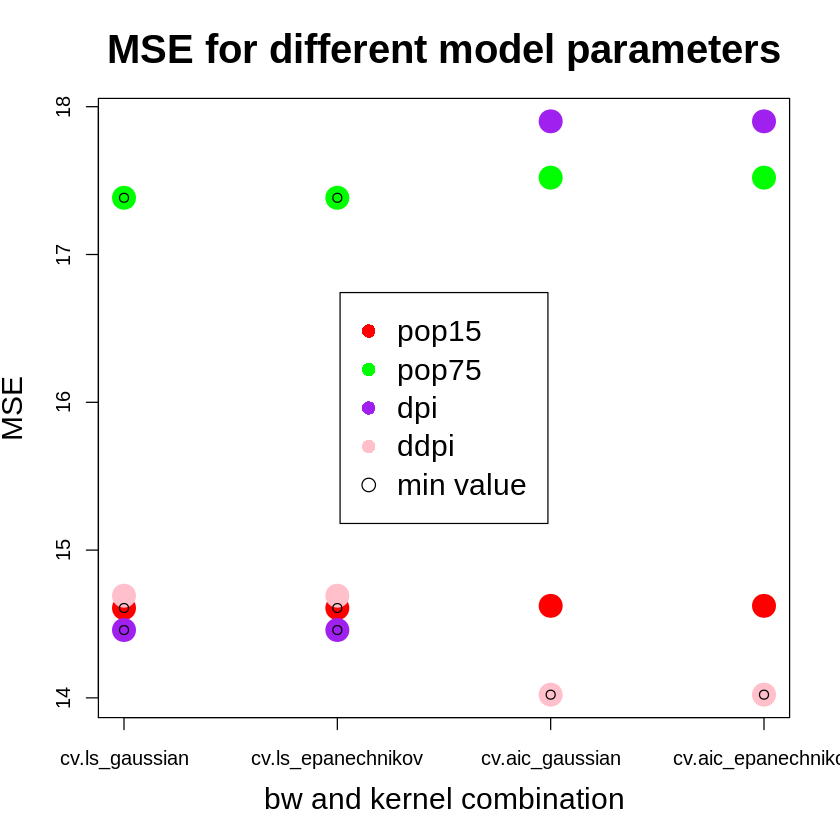

In [129]:
# визуализируем результаты

plot(M$pair_number, M$MSE, col = M$color, xaxp = c(-1, -1, 1),
      main = 'MSE for different model parameters', cex.main = 2, 
      xlab = 'bw and kernel combination', ylab = 'MSE', lwd = 12, cex.lab = 1.5)
for (v in M$var[c(4, 8, 12, 16)]){
  min_val = min(M[M$var == v, ]$MSE)
  M_min = M[M$MSE == min_val, 3:4]
  points(M_min$pair_number, M_min$MSE, col = 'black')
}

legend(col = c(M$color[c(4, 8, 12, 16)], 'black'), x = "center", cex = 1.5,
        legend = c(M$var[c(4, 8, 12, 16)], 'min value'), pch = c(rep(16, 4), 1))
axis(1, labels = M$bw_ker[1:4], at = 1:4, padj = 0.3)

Как видно, метод выбора ядра не влияет на среднеквадратичную ошибку, в то время как для 3 из 4 переменных лучшим в смысле СКО методом выбора параметра bandwidth оказался обобщённый метод кросс-проверки cv.ls

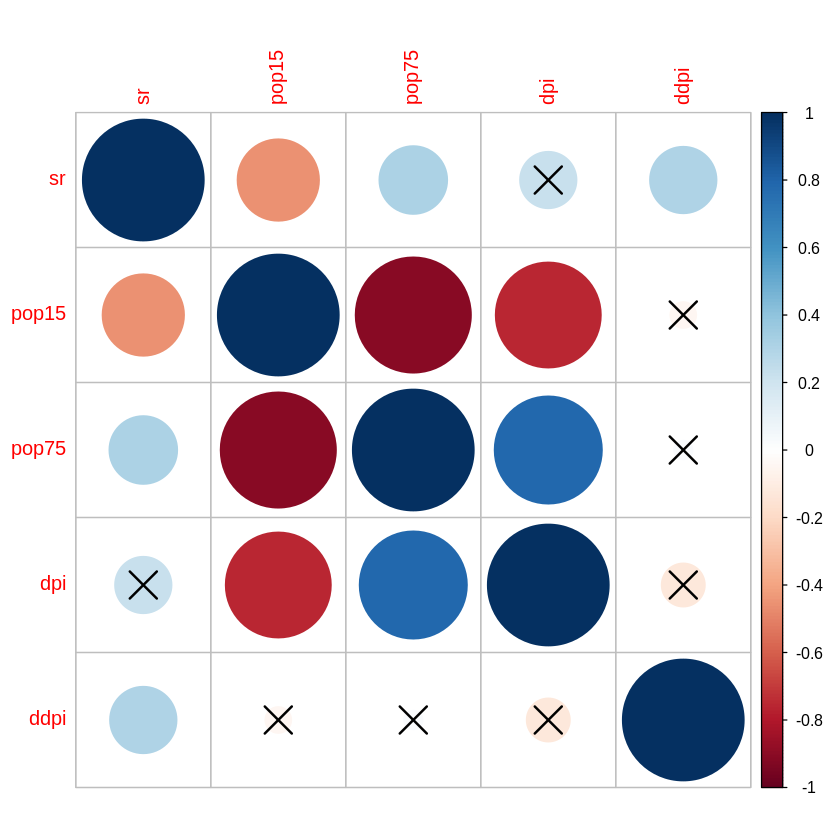

In [148]:
#2.2
# Выберем 2 переменные, которые наилучшим образом объясняют коэффициент 
# персональных сбережений

# посмотрим на корреляцию величин в датасете
library(corrplot)
library(dplyr)

matr = rcorr(as.matrix(LifeCycleSavings))
par(mfcol = c(1, 1), pty = 'm', mar = c(1, 1, 1, 1))
corrplot(matr$r, p.mat=as.matrix(mutate_all(as.data.frame(matr$P), ~if_else(is.na(.), 0, .))))


In [149]:
# Еще раз проверим вывод линейной модели для всех переменных
L_all = lm(sr ~ ., data = LifeCycleSavings)
summary(L_all)


Call:
lm(formula = sr ~ ., data = LifeCycleSavings)

Residuals:
    Min      1Q  Median      3Q     Max 
-8.2422 -2.6857 -0.2488  2.4280  9.7509 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept) 28.5660865  7.3545161   3.884 0.000334 ***
pop15       -0.4611931  0.1446422  -3.189 0.002603 ** 
pop75       -1.6914977  1.0835989  -1.561 0.125530    
dpi         -0.0003369  0.0009311  -0.362 0.719173    
ddpi         0.4096949  0.1961971   2.088 0.042471 *  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 3.803 on 45 degrees of freedom
Multiple R-squared:  0.3385,	Adjusted R-squared:  0.2797 
F-statistic: 5.756 on 4 and 45 DF,  p-value: 0.0007904


Выбираем pop15 и ddpi в качестве двух переменных, которые наилучшим образом объясняют коэффициент персональных сбережений. Во-первых, это две значимые переменные в линейной регрессии. Во-вторых, значимая корреляция есть между sr и тремя переменными (pop75, pop15 и ddpi), но две из них сами между собой очень сильно коррелируют (pop75, pop15), поэтому из них выбираем более значимую (pop15) и оставшуюся ddpi. Также по результатам вычисления MSE pop75 показала в среднем худший результат.

In [186]:
#3
library(fANCOVA)

set.seed(888)
V1 = 2
V2 = 5

dt = sort(sample(nrow(LifeCycleSavings), nrow(LifeCycleSavings) * 0.8))
train = LifeCycleSavings[dt, c(1, V1, V2)]
test = LifeCycleSavings[-dt, c(1, V1, V2)]

# построим модели
L_2 = lm(sr ~ ., data = train)
Loess = loess.as(train[, 2:3], train$sr, criterion = "gcv")

# оценим параметры модели на обучающем наборе данных

sprintf("MSE на обучающей выборке для линейной модели равен %.2f", 
        mean((train$sr - fitted(L_2)) ** 2))
sprintf("MSE на обучающей выборке для модели LOESS равен %.2f", 
        mean((train$sr - fitted(Loess)) ** 2))

# проверим качество моделей на тестовом наборе данных

sprintf("MSE на тестовой выборке для линейной модели равен %.2f", 
        mean((train$sr - predict(L_2, test[, 2:3], type = 'response')) ** 2))
colnames(test) = c('sr', 'x1', 'x2')
sprintf("MSE на тестовой выборке для модели LOESS равен %.2f", 
        mean((train$sr - predict(Loess, test[, 2:3], type = 'response')) ** 2))

# выясняем, какая из построенных моделей является более точной

# И на обучающей, и на тестовой выборке лучшее качество по MSE показала модель 
# LOESS. Однако стоит иметь в виду, что выборка у нас достаточно маленькая, и
# и для другого разбиения результат мог получиться совсем другой.

[1] "MSE на обучающей выборке для линейной модели равен 13.16"

[1] "MSE на обучающей выборке для модели LOESS равен 8.53"

[1] "MSE на тестовой выборке для линейной модели равен 29.04"

[1] "MSE на тестовой выборке для модели LOESS равен 19.71"